# Predicting TED Talks Views with ML Models
In this notebook I've done some simple feature engineering on the TED Talks dataset and I've built machine learning models (Random Forest, XGBRegressor, ExtraTreesRegressor, and LGBMRegressor) and optimised their hyperparameters to predict the number of TED Talks views. I've made use of the following kernels to create this notebook:
* https://www.kaggle.com/rounakbanik/ted-data-analysis
* https://www.kaggle.com/holfyuen/what-makes-a-popular-ted-talk
* https://www.kaggle.com/tristanmoser/predicting-a-powerful-idea-a-ted-talk-analysis



In [ ]:

import os 
os.environ['KAGGLE_CONFIG_DIR']='/content'

# load libraries
import time
import warnings
import random
import pandas as pd
import datetime
#import lightgbm as lgb
import xgboost as xgb
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
# GridSearchCV
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import metrics
#from mlxtend.regressor import StackingCVRegressor

# ignore warnings
warnings.filterwarnings('ignore')

# load data
data = pd.read_csv("/content/ted_main.csv")
data.shape

(2550, 17)

In [ ]:
data.head()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# TED Talks Data Analysis
## Cleaning up the data
Various datasets frequently have missing values, so I start off by checking whether the TED Talks dataset has any. 

In [ ]:
pd.isnull(data).sum()

comments              0
description           0
duration              0
event                 0
film_date             0
languages             0
main_speaker          0
name                  0
num_speaker           0
published_date        0
ratings               0
related_talks         0
speaker_occupation    6
tags                  0
title                 0
url                   0
views                 0
dtype: int64

There are only 6 null values in the **speaker_occupation** feature, I will fill in those missing values with a default 'Other' value.

In [ ]:
for index, row in data.iterrows():
    if pd.isnull(row['speaker_occupation']):
        data['speaker_occupation'][index] = 'Other'

## related_talks
Here I print out the **related_talks** feature so I check what it looks like.

In [ ]:
data['related_talks'][0]

'[{\'id\': 865, \'hero\': \'https://pe.tedcdn.com/images/ted/172559_800x600.jpg\', \'speaker\': \'Ken Robinson\', \'title\': \'Bring on the learning revolution!\', \'duration\': 1008, \'slug\': \'sir_ken_robinson_bring_on_the_revolution\', \'viewed_count\': 7266103}, {\'id\': 1738, \'hero\': \'https://pe.tedcdn.com/images/ted/de98b161ad1434910ff4b56c89de71af04b8b873_1600x1200.jpg\', \'speaker\': \'Ken Robinson\', \'title\': "How to escape education\'s death valley", \'duration\': 1151, \'slug\': \'ken_robinson_how_to_escape_education_s_death_valley\', \'viewed_count\': 6657572}, {\'id\': 2276, \'hero\': \'https://pe.tedcdn.com/images/ted/3821f3728e0b755c7b9aea2e69cc093eca41abe1_2880x1620.jpg\', \'speaker\': \'Linda Cliatt-Wayman\', \'title\': \'How to fix a broken school? Lead fearlessly, love hard\', \'duration\': 1027, \'slug\': \'linda_cliatt_wayman_how_to_fix_a_broken_school_lead_fearlessly_love_hard\', \'viewed_count\': 1617101}, {\'id\': 892, \'hero\': \'https://pe.tedcdn.com/ima

After that I split the string by its commas and then by the semi-column to get the middle element, which is the views of all related talks.

In [ ]:
data['related_views'] = 0

for index, row in data.iterrows():
    vids = row['related_talks'].split(',')
    counter = 0
    total = 0
    for views in vids:
        if 'viewed_count' in views:
            view = views.split(':')
            # get rid of brackets and spaces
            view[1] = view[1].replace("]", "")
            view[1] = view[1].replace(" ", "")
            view[1] = view[1].replace("}", "")
            total+=int(view[1])
            counter+=1
    data['related_views'][index] = total/counter

## published_date, filmed_date
From these two features I extract day of the week, month, and year.

In [ ]:
data['published_date'] = data['published_date'].apply(lambda x: datetime.date.fromtimestamp(int(x)))
data['day'] = data['published_date'].apply(lambda x: x.weekday())
data['month'] = data['published_date'].apply(lambda x: x.month)
data['year'] = data['published_date'].apply(lambda x: x.year)
data['film_date'] = data['film_date'].apply(lambda x: datetime.date.fromtimestamp(int(x)))
data['day_film'] = data['film_date'].apply(lambda x: x.weekday())
data['month_film'] = data['film_date'].apply(lambda x: x.month)
data['year_film'] = data['film_date'].apply(lambda x: x.year)

Here I categorise the data which is preferable over using numbers.

In [ ]:
to_cat = {"day":   {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thurday", 4: "Friday", 5: "Saturday",
                    6: "Sunday" },
          "month": {1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June", 7: "July", 8: "August", 
                    9: "September", 10: "October", 11: "November", 12: "December"},
          "year":  {2006: "2006", 2007: "2007", 2008: "2008", 2009: "2009", 2010: "2010", 2011: "2011", 2012: "2012", 
                    2013: "2013", 2014: "2014", 2015: "2015", 2016: "2016", 2017: "2017"},
          "day_film":   {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thurday", 4: "Friday", 5: "Saturday",
                    6: "Sunday" },
          "month_film": {1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June", 7: "July", 8: "August", 
                    9: "September", 10: "October", 11: "November", 12: "December"},
          "year_film":  {2006: "2006", 2007: "2007", 2008: "2008", 2009: "2009", 2010: "2010", 2011: "2011", 2012: "2012", 
                    2013: "2013", 2014: "2014", 2015: "2015", 2016: "2016", 2017: "2017"}}

data.replace(to_cat, inplace=True)

## event
I check the number of unique event names then list all of them:

In [ ]:
print('Number of unique events: ',data['event'].unique().shape[0])
data['event'].unique()

Number of unique events:  355


array(['TED2006', 'TED2004', 'TED2005', 'TEDGlobal 2005', 'TEDSalon 2006',
       'TED2003', 'TED2007', 'TED2002', 'TEDGlobal 2007',
       'TEDSalon 2007 Hot Science', 'Skoll World Forum 2007', 'TED2008',
       'TED1984', 'TED1990', 'DLD 2007', 'EG 2007', 'TED1998',
       'LIFT 2007', 'TED Prize Wish', 'TEDSalon 2009 Compassion',
       'Chautauqua Institution', 'Serious Play 2008', 'Taste3 2008',
       'TED2001', 'TED in the Field', 'TED2009', 'EG 2008',
       'Elizabeth G. Anderson School', 'TEDxUSC', 'TED@State',
       'TEDGlobal 2009', 'TEDxKC', 'TEDIndia 2009',
       'TEDSalon London 2009', 'Justice with Michael Sandel',
       'Business Innovation Factory', 'TEDxTC',
       'Carnegie Mellon University', 'Stanford University',
       'AORN Congress', 'University of California', 'TEDMED 2009',
       'Royal Institution', 'Bowery Poetry Club', 'TEDxSMU',
       'Harvard University', 'TEDxBoston 2009', 'TEDxBerlin', 'TED2010',
       'TEDxAmsterdam', 'World Science Festival', 

The dataset has 355 unique event names but from the looks of it, lots of these names can be categorised together as they are quite similar. I break down the event names in the following 11 categories (each consisting of at least 5 samples).

In [ ]:
# initialise all values as 'Other' to assign this category
# to all entries that don't fit into the chosen categories
data['event_category'] = 'Other'

for i in range(len(data)):
    if data['event'][i][0:5]=='TED20':
        data['event_category'][i] = 'TED2000s'
    elif data['event'][i][0:5]=='TED19':
        data['event_category'][i] = 'TED1900s'
    elif data['event'][i][0:4]=='TEDx':
        data['event_category'][i] = "TEDx"
    elif data['event'][i][0:7]=='TED@BCG':
        data['event_category'][i] = 'TED@BCG'
    elif data['event'][i][0:4]=='TED@':
        data['event_category'][i] = "TED@"
    elif data['event'][i][0:8]=='TEDSalon':
        data['event_category'][i] = "TEDSalon"
    elif data['event'][i][0:9]=='TEDGlobal':
        data['event_category'][i] = 'TEDGlobal'
    elif data['event'][i][0:8]=='TEDWomen':
        data['event_category'][i] = 'TEDWomen'
    elif data['event'][i][0:6]=='TEDMED':
        data['event_category'][i] = 'TEDMED'
    elif data['event'][i][0:3]=='TED':
        data['event_category'][i] = 'TEDOther'

I check whether each categoies can be found in the dataset.

In [ ]:
data['event_category'].unique()

array(['TED2000s', 'TEDGlobal', 'TEDSalon', 'Other', 'TED1900s',
       'TEDOther', 'TEDx', 'TED@', 'TEDMED', 'TEDWomen', 'TED@BCG'],
      dtype=object)

In [ ]:
data.head(1)


,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,...,url,views,related_views,day,month,year,day_film,month_film,year_film,event_category
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,2006-02-25,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,2006-06-27,...,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,3027062,Tuesday,June,2006,Saturday,February,2006,TED2000s


## Final touches on the dataset
I take out the views and comments and the rest of the features I won't be using.

# New section

In [ ]:
views = data['views']
comments = data['comments']
data = data.drop(['comments', 'description', 'event', 'film_date', 'main_speaker', 'name', 'published_date', 'ratings', 
           'related_talks', 'tags', 'title', 'url', 'views', 'speaker_occupation', ], 1)
data.head()

,duration,languages,num_speaker,related_views,day,month,year,day_film,month_film,year_film,event_category
0,1164,60,1,3027062,Tuesday,June,2006,Saturday,February,2006,TED2000s
1,977,43,1,1118767,Tuesday,June,2006,Saturday,February,2006,TED2000s
2,1286,26,1,1846195,Tuesday,June,2006,Friday,February,2006,TED2000s
3,1116,35,1,776189,Tuesday,June,2006,Sunday,February,2006,TED2000s
4,1190,48,1,1907337,Tuesday,June,2006,Wednesday,February,2006,TED2000s


In [ ]:
#data is datframe
#csv_data = data.to_csv() 


data.to_csv(r'C:\Users\mahad\Documents\cleaned_dataframe.csv', index=False, header=True)



In [ ]:
print(data.columns.tolist())

['duration', 'languages', 'num_speaker', 'related_views', 'day', 'month', 'year', 'day_film', 'month_film', 'year_film', 'event_category']


I apply **One-Hot-Encoding** on the categorical attributes and get the data ready for training machine learning models. Then I print out the dimensions of the final dataset.

In [ ]:
# data2 = data.filter(like='_tag', axis=1)
# data = data.drop(data2.columns, 1)
# data.head()
data_final = pd.get_dummies(data)
data_final.shape

(2550, 89)

# Machine Learning
## Random Forest
First model I will be testing with is **Random Forest** as this is the one I'm most comfortable with. I will then explore some other ML models, optimise the hyperparameters of each model, and combine those into an ensebmle model.

I split the dataset in training (90%) and test (10%) sets. The test data will be later used to validate the ML models on unseen data. I start off with a **Random Forest** as it's quite a powerful model that can be used as a baseline. I will use **Mean Absolute Error (MAE)** to measure the error as it will give us a more intuitive understanding of how accurate the model is. Additionally, using **Mean Squared Error (MSE)** to predict target variables with large values (such as the TED Talks views I'm working with) can lead to problems.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_final, views, test_size=0.1, random_state=121212)

The baseline Random Forest model seems to have overfitted. Together with the **MAE** of the model I also print the **mean** and **std** of the target variables. Judging by the high variance of the data, it's safe to conclude that the model is performing reasonably well.

In [ ]:
rf = RandomForestRegressor(criterion='mae',max_depth=15, max_features=45, n_estimators=500, min_samples_leaf=2, min_samples_split=2,
                           random_state=2019)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print('Training MAE: {:0.2f}'.format(metrics.mean_absolute_error(y_train, y_pred)))
print('Test MAE: {:0.2f}'.format(metrics.mean_absolute_error(y_test, y_test_pred)))
print('Views mean: {:0.2f}'.format(views.mean()))
print('Views std: {:0.2f}'.format(views.std()))

Training MAE: 458747.60
Test MAE: 646002.69
Views mean: 1698297.48
Views std: 2498479.37


# Feature Importances

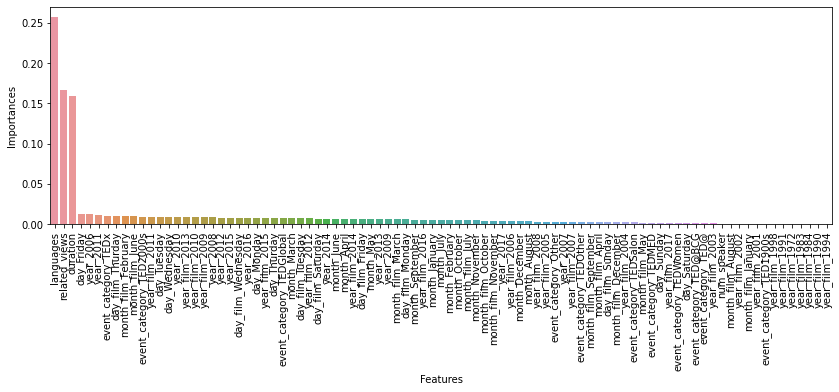

In [ ]:
importances = pd.DataFrame({'Features': X_train.columns, 
                                'Importances': rf.feature_importances_})
    
importances.sort_values(by=['Importances'], axis='index', ascending=False, inplace=True)
fig = plt.figure(figsize=(14, 4))
sns.barplot(x='Features', y='Importances', data=importances)
plt.xticks(rotation='vertical')
plt.show()


## XGBRegressor
Good accuracy, the model tends to overfit quite easily when **n_estimators > 20**. Maybe it's worth exploring wether we can use a higher **n_estimators** value while using the other hyperparameters to reguralise the model.

In [ ]:
xgbr = xgb.XGBRegressor(criterion='mae', earning_rate=0.1, max_depth=10, subsample=0.5, n_estimators=20, min_child_weight=2, random_state=2019)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_train)
y_test_pred = xgbr.predict(X_test)
print('Training MAE: {:0.2f}'.format(metrics.mean_absolute_error(y_train, y_pred)))
print('Test MAE: {:0.2f}'.format(metrics.mean_absolute_error(y_test, y_test_pred)))

[10:38:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Training MAE: 495106.41
Test MAE: 640284.68


## ExtraTreesRegressor
ExtraTreesRegressor yields the best accuracy, maybe can reguralise the model better as the gap between Training and Test MAE is quite big?

In [29]:
et = ExtraTreesRegressor(criterion='mae', max_depth=30, n_estimators=1000, random_state=2019, min_samples_leaf=2, min_samples_split=6)
et.fit(X_train, y_train)
y_pred = et.predict(X_train)
y_test_pred = et.predict(X_test)
print('Training MAE: {:0.2f}'.format(metrics.mean_absolute_error(y_train, y_pred)))
print('Test MAE: {:0.2f}'.format(metrics.mean_absolute_error(y_test, y_test_pred)))

Training MAE: 297677.09
Test MAE: 588787.82


# Model evaluation 

9. Final selection of the model
i choose MAE as  deciding factor of our model selection because of the following reasons:



MAE doesn’t increase with outliers. MAE is linear 

The best performing regressor model for this dataset is Random Forest Regressor on the basis of MAE.